In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
import LPR

In [2]:
def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [3]:
idx = 2
lpr = LPR.LPR()

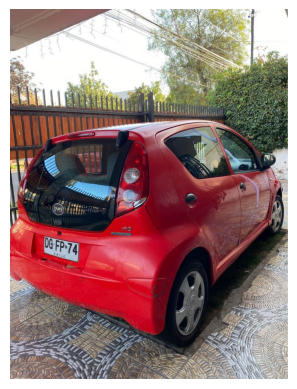

In [4]:
img = cv2.imread(f"./imgscl/{idx:03}.png")
plot_image(img, False)

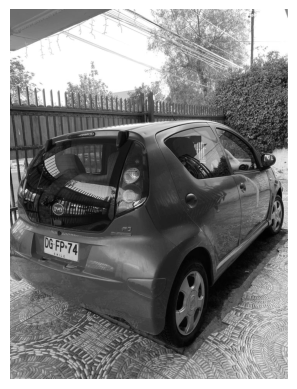

In [5]:
gray = lpr.grayscale(img)
plot_image(gray)

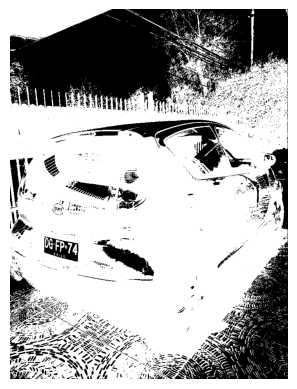

In [6]:
thresh = lpr.apply_threshold(gray)
plot_image(thresh)

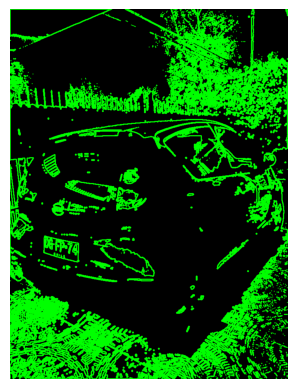

In [7]:
contours = lpr.find_contours(thresh)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

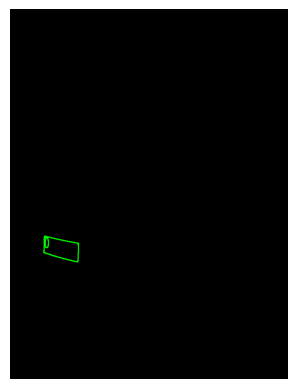

In [8]:
candidates = lpr.filter_candidates(gray, contours)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , candidates, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

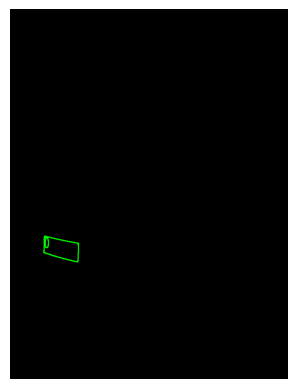

In [9]:
license = lpr.get_lowest_candidate(candidates)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , [license], -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

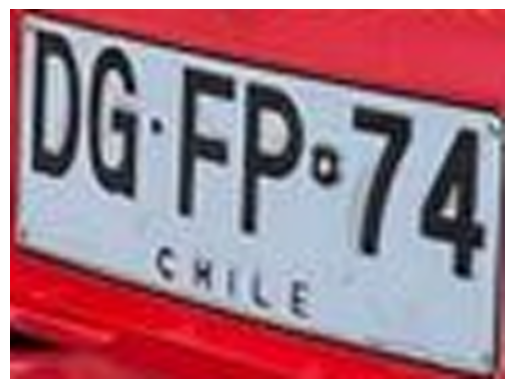

In [10]:
cropped = lpr.crop_license_plate(gray, license)
cropped2 = lpr.crop_license_plate(img, license)
plot_image(cropped2, False)

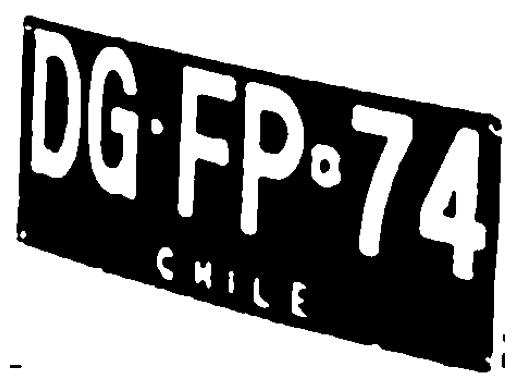

In [11]:
thresh_cropped = lpr.apply_adaptive_threshold(cropped)
plot_image(thresh_cropped)

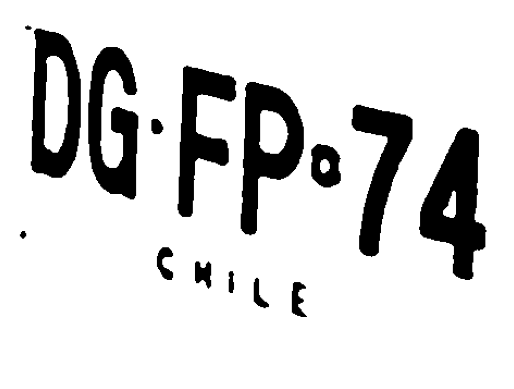

In [12]:
clear_border = lpr.clear_border(thresh_cropped)
final = lpr.invert_image(clear_border)
plot_image(final)

In [13]:
psm = 7
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
options += " --psm {}".format(psm)
txt = pytesseract.image_to_string(final, config=options)
print(txt[:2], txt[2:4], txt[4:6]) #print de los datos

OG FP 74
